In [160]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm

with open('training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

In [161]:
from itertools import chain
def SortLabels(GF, nodeindex, labeldict):
    neigh = list(GF.neighbors(nodeindex))#GF.adj[i].copy()
    label = [labeldict[i] for i in neigh]
    label = list(chain.from_iterable(label))
    label.sort()
    return label
    # l = pd.DataFrame.from_dict(l)
    # l = l.sort_values(by='labels', axis='columns').T
    # x = list(l['labels'])

    # # print(l)
    # x = list(chain.from_iterable(x))
    # print(x)
    # return x

def GlueLabels(nodelabeldict, index, newlist):
    nodelbl = nodelabeldict[index][0]
    x = ''.join([str(s) for s in newlist])
    return str(nodelbl) + x

def dictToArray(dict):
    a = np.array(list(dict.items()), dtype=object )
    a[:,1] = list(chain.from_iterable(a[:,1]))
    return a

def draw(G):
    pos = nx.spring_layout(G, seed=1, k=0.3)
    nx.draw(G, pos)
    node_labels = nx.get_node_attributes(G, "labels")
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8);

def getnodelblarr(GF):
    #Dictionary of labels for graph
    NLbl_dict = nx.get_node_attributes(GF, 'labels')
    #Generate new lbls for each vertex
    newlabels = []
    for v in NLbl_dict:
        sortedlbls = SortLabels(GF, v, NLbl_dict)
        gluedlbl = GlueLabels(NLbl_dict, v, sortedlbls)
        newlabels.append(gluedlbl)

    #Array with columns: node, label, newlabel
    Nlbl_arra0 = np.c_[dictToArray(NLbl_dict), newlabels]
    #And sort
    Nlbl_arra0 = Nlbl_arra0[Nlbl_arra0[:,2].argsort()]
    return Nlbl_arra0

def hashtodic(BIGDIC, newlblarr, currentmax):
    #Get unique entries
    a = np.unique(newlblarr[:,2]) 
    #Get those that are new also
    a = [a[i] for i in range(len(a)) if a[i] not in BIGDIC]
    #Hash values
    b = np.arange(len(a))+currentmax
    currentmax = currentmax+len(b)
    dic1 = BIGDIC | {a[i] : b[i] for i in range(len(a))}
    #relabel
    newlblarr = np.c_[newlblarr, [dic1[newlblarr[:,2][_]] for _ in range(len(newlblarr))]]    

    return dic1, pd.DataFrame(newlblarr, columns=["node", 'oldlbl', 'hashed', 'newlbl']), currentmax
 
def assignewlabels(GF, nlblarr):
    newdict = {nlblarr['node'][i] : [nlblarr['newlbl'][i]] for i in range(len(nlblarr))}
    H = GF.copy()
    nx.set_node_attributes(H, newdict, name='labels')
    return H


#### Loop

In [ ]:
# # h = 4
# # currentmax = 49
# # for _ in range(h):
# NEWLBL = []
# for G0 in train_graphs:
#     #Biggest connected component
#     G = G0.subgraph(sorted(nx.connected_components(G0), key=len, reverse=True)[0])

#     #Dictionary of labels for graph
#     NLbl_dict = nx.get_node_attributes(G, 'labels')
#     #Generate new lbls for each vertex
#     newlabels = []
#     for v in NLbl_dict:
#         sortedlbls = SortLabels(G, v)
#         gluedlbl = GlueLabels(NLbl_dict, v, sortedlbls)
#         newlabels.append(gluedlbl)
    
#     #Array with columns: node, label, newlabel
#     Nlbl_arra = np.c_[dictToArray(NLbl_dict), newlabels]
#     #And sort
#     Nlbl_arra = Nlbl_arra[Nlbl_arra[:,2].argsort()]
        
        

#### Test

In [219]:
h = 4
hashedgraphs = [[] for _ in range(h)]
hashedgraphs.insert(0, train_graphs.copy())
Alphabet = {}
currentmax = 49
hctr=1

l = [[] for _ in range(len(train_graphs))]
for i in range(len(train_graphs)):
    a = nx.get_node_attributes(hashedgraphs[0][i], 'labels').values()
    a = list(chain.from_iterable(a))
    l[i] = l[i] + a
pd.value_counts(l[0])

for hctr in (range(1, h+1)):
    for i in tqdm(range(len(train_graphs)//10)):
        Gi = hashedgraphs[0][i]# Gi = train_graphs[i]
        #get biggest connected subgraph
        Gi = Gi.subgraph(sorted(nx.connected_components(Gi), key=len, reverse=True)[0])
        #Array with columns: node, label, newlabel
        lblarri = getnodelblarr(Gi)
        #Update big alphabet, hash
        Alphabet, lblarri, currentmax = hashtodic(Alphabet, lblarri, currentmax=currentmax)
        #sort and reset index
        lblarri = lblarri.sort_values(by='node')
        lblarri = lblarri.reset_index(drop=True)
        #relabel to a different graph
        Hi = assignewlabels(Gi, lblarri)
        #assign graph-value
        hashedgraphs[0][i] = Hi
        #add counts of labels
        a = nx.get_node_attributes(hashedgraphs[0][i], 'labels').values()
        a = list(chain.from_iterable(a))
        l[i] = l[i] + a

Alphabet = {f'{i}': i for i in range(49)} | Alphabet
# Alphabet

100%|██████████| 600/600 [00:02<00:00, 215.63it/s]


In [263]:
M = np.zeros((len(train_graphs), len(Alphabet)+100))
for i in tqdm(range(len(train_graphs))):
    a = pd.value_counts(l[i])
    M[i, list(a.index)] = a.values

100%|██████████| 6000/6000 [00:02<00:00, 2042.02it/s]


In [189]:
DICT = {f'{i}': i for i in range(0, 49)} | Alphabet

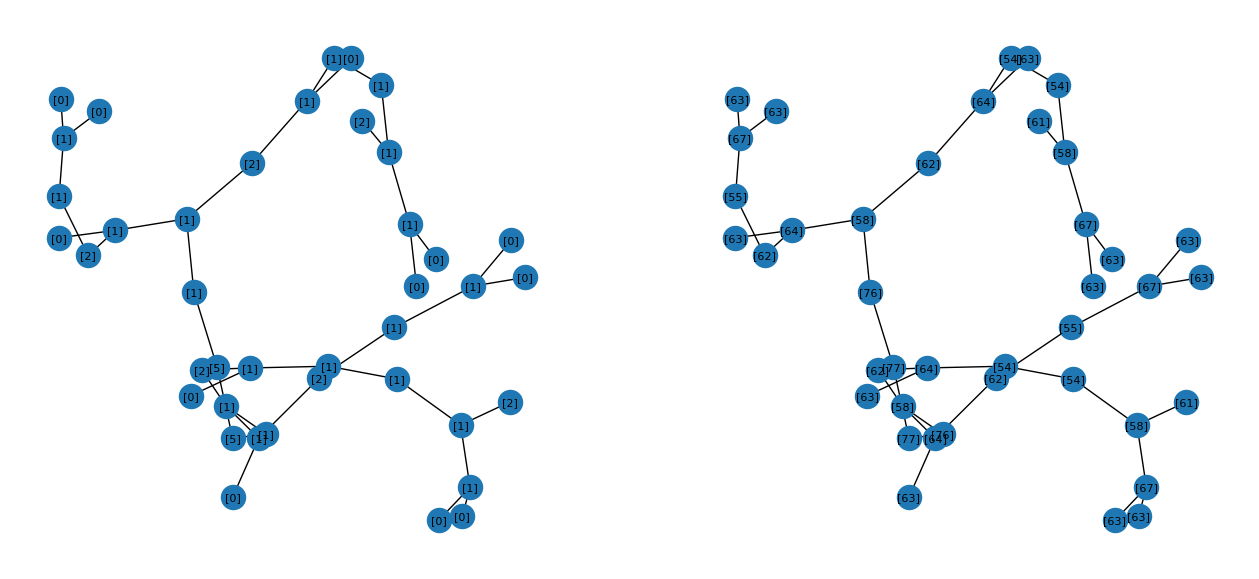

In [163]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
draw(hashedgraphs[0][9])
plt.subplot(2,2,2)
draw(hashedgraphs[1][9])
# plt.subplot(2,2,3)
# # draw(train_graphs[59])
# nx.draw(train_graphs[9], pos, with_labels=True)
# plt.subplot(2,2,4)
# draw(train_graphs[0])

In [38]:


# G0 = train_graphs[0]
# G0 = G0.subgraph(sorted(nx.connected_components(G0), key=len, reverse=True)[0])
# Nlbl_arra0 = getnodelblarr(G0)

# DICT = {}
# DICT, Nlbl_arra0, currentmax = addtoDic(DICT, Nlbl_arra0, currentmax=49)
# Nlbl_arra0 = Nlbl_arra0.sort_values(by='node')
# print(DICT) #, currentmax, len(BIGDIC), Nlbl_arra0, sep='\n')

# G1 = train_graphs[1]
# G1 = G1.subgraph(sorted(nx.connected_components(G1), key=len, reverse=True)[0])
# Nlbl_arra1 = getnodelblarr(G1)
# DICT, Nlbl_arra1, currentmax = addtoDic(DICT, Nlbl_arra1, currentmax=currentmax)
# Nlbl_arra1 = Nlbl_arra1.sort_values(by='node')
# print(DICT, len(DICT))#, currentmax, len(BIGDIC), Nlbl_arra1, sep='\n')



# plt.subplot(2,1,1)
# draw(G0)
# H0 = assignewlabels(G0, Nlbl_arra0)
# plt.subplot(2,1,2)
# draw(H0)
